In [1]:
import pandas as pd
from siuba import *
from siuba.siu import call
from plotnine import *
import json
import matplotlib.pyplot as pp
import tidytext
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import datetime

import numpy as np

np.random.seed(500)

In [2]:
# load all the data
commits_raw = pd.read_pickle("../data/graphql/commits_total.pkl")
commits_df = pd.DataFrame()
for repo in commits_raw:
    commits_df = pd.concat([commits_df, pd.DataFrame(repo)])


In [3]:
issues_total = pd.read_pickle("../data/graphql/issues_total.pkl")
issuespr_total = pd.read_pickle("../data/graphql/issuespr_total.pkl")
issues_df = pd.concat((pd.DataFrame(issues_total), pd.DataFrame(issuespr_total)))


In [4]:
with open("../data/repos/topic_combined.json", "r") as read_file:
    raw = json.load(read_file)
repo_df = pd.DataFrame(raw)


# find relevant columns with correlation matricies

In [5]:
# select relevant columns
selected_df = (
    repo_df
    >> select(
        ~_.endswith("url"),
        ~_.homepage,
        ~_.size,
        ~_.web_commit_signoff_required,
        ~_.visibility,
        ~_.score,
        ~_.default_branch,
        ~_.permissions,
    )
    >> filter(_.private == False, _.archived == False, _.disabled == False)
    >> select(~_.archived, ~_.disabled)
)


In [6]:
selected_df.columns

Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'description',
       'fork', 'created_at', 'updated_at', 'pushed_at', 'stargazers_count',
       'watchers_count', 'language', 'has_issues', 'has_projects',
       'has_downloads', 'has_wiki', 'has_pages', 'has_discussions',
       'forks_count', 'open_issues_count', 'license', 'allow_forking',
       'is_template', 'topics', 'forks', 'open_issues', 'watchers'],
      dtype='object')

In [7]:
(selected_df
    >> distinct(_.id)
    >> count()
)

,n
0,986


In [8]:
selected_df.corr()

/var/folders/5w/dhznpltj14n3nxr4fybjj8_w0000gn/T/ipykernel_71632/4130664976.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,id,private,fork,stargazers_count,watchers_count,has_issues,has_projects,has_downloads,has_wiki,has_pages,has_discussions,forks_count,open_issues_count,allow_forking,is_template,forks,open_issues,watchers
id,1.000000,NaN,NaN,-0.289823,-0.289823,0.014164,0.063037,-0.006833,0.105566,-0.048536,-0.134018,-0.270637,-0.283314,NaN,0.011518,-0.270637,-0.283314,-0.289823
private,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stargazers_count,-0.289823,NaN,NaN,1.000000,1.000000,0.021781,-0.002645,0.005431,-0.092477,0.100473,0.172367,0.851789,0.452322,NaN,-0.016101,0.851789,0.452322,1.000000
watchers_count,-0.289823,NaN,NaN,1.000000,1.000000,0.021781,-0.002645,0.005431,-0.092477,0.100473,0.172367,0.851789,0.452322,NaN,-0.016101,0.851789,0.452322,1.000000
has_issues,0.014164,NaN,NaN,0.021781,0.021781,1.000000,0.419024,-0.004744,0.328706,-0.002435,0.034458,0.008747,0.023713,NaN,-0.011656,0.008747,0.023713,0.021781
has_projects,0.063037,NaN,NaN,-0.002645,-0.002645,0.419024,1.000000,-0.008671,0.721320,-0.032895,-0.053396,0.010471,-0.012836,NaN,0.026851,0.010471,-0.012836,-0.002645
has_downloads,-0.006833,NaN,NaN,0.005431,0.005431,-0.004744,-0.008671,1.000000,0.089662,0.011830,0.011349,0.005021,0.003604,NaN,0.005530,0.005021,0.003604,0.005431
has_wiki,0.105566,NaN,NaN,-0.092477,-0.092477,0.328706,0.721320,0.089662,1.000000,-0.115052,-0.167513,-0.088299,-0.154708,NaN,-0.011668,-0.088299,-0.154708,-0.092477
has_pages,-0.048536,NaN,NaN,0.100473,0.100473,-0.002435,-0.032895,0.011830,-0.115052,1.000000,0.222181,0.057312,0.080330,NaN,-0.032382,0.057312,0.080330,0.100473


watchers == watchers_count == stargazers_count

forks == forks_count

issues == open_issues_count

forks_count <> stargazers_count == 0.851789 corr


In [9]:
(
    selected_df
    >> select(
        ~_.watchers,
        ~_.fork,
        ~_.watchers_count,
        _.stargazers_count,
        _.forks_count,
        ~_.forks,
        _.open_issues_count,
        ~_.open_issues,
        ~_.forks_count,
        ~_.private
    )
).corr()


/var/folders/5w/dhznpltj14n3nxr4fybjj8_w0000gn/T/ipykernel_71632/208152933.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,id,stargazers_count,has_issues,has_projects,has_downloads,has_wiki,has_pages,has_discussions,open_issues_count,allow_forking,is_template
id,1.000000,-0.289823,0.014164,0.063037,-0.006833,0.105566,-0.048536,-0.134018,-0.283314,NaN,0.011518
stargazers_count,-0.289823,1.000000,0.021781,-0.002645,0.005431,-0.092477,0.100473,0.172367,0.452322,NaN,-0.016101
has_issues,0.014164,0.021781,1.000000,0.419024,-0.004744,0.328706,-0.002435,0.034458,0.023713,NaN,-0.011656
has_projects,0.063037,-0.002645,0.419024,1.000000,-0.008671,0.721320,-0.032895,-0.053396,-0.012836,NaN,0.026851
has_downloads,-0.006833,0.005431,-0.004744,-0.008671,1.000000,0.089662,0.011830,0.011349,0.003604,NaN,0.005530
has_wiki,0.105566,-0.092477,0.328706,0.721320,0.089662,1.000000,-0.115052,-0.167513,-0.154708,NaN,-0.011668
has_pages,-0.048536,0.100473,-0.002435,-0.032895,0.011830,-0.115052,1.000000,0.222181,0.080330,NaN,-0.032382
has_discussions,-0.134018,0.172367,0.034458,-0.053396,0.011349,-0.167513,0.222181,1.000000,0.273247,NaN,0.024793
open_issues_count,-0.283314,0.452322,0.023713,-0.012836,0.003604,-0.154708,0.080330,0.273247,1.000000,NaN,-0.023169
allow_forking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
refined_df = (
    selected_df
    >> select(
        ~_.watchers,
        ~_.fork,
        ~_.watchers_count,
        _.stargazers_count,
        _.forks_count,
        ~_.forks,
        _.open_issues_count,
        ~_.open_issues,
        ~_.forks_count,
        ~_.private
    )
)

In [11]:
refined_df.columns

Index(['id', 'node_id', 'name', 'full_name', 'owner', 'description',
       'created_at', 'updated_at', 'pushed_at', 'stargazers_count', 'language',
       'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages',
       'has_discussions', 'open_issues_count', 'license', 'allow_forking',
       'is_template', 'topics'],
      dtype='object')

https://github.com/orgs/community/discussions/24442
The difference is that pushed_at represents the date and time of the last commit, whereas the updated_at represents the date and time of the last change the the repository. A change to the repository might be a commit, but it may also be other things, such as changing the description of the repo, creating wiki pages

In [12]:
from siuba.experimental.datetime import floor_date, ceil_date
refined_df['created_at'] = refined_df.created_at.astype("datetime64[ns]")
refined_df['pushed_at'] = refined_df.pushed_at.astype("datetime64[ns]")
refined_df['language'] = refined_df.language.astype("category")
refined_df = (refined_df 

    >> mutate(
        age_days = (datetime.datetime(2023, 1, 21) - _.created_at).dt.components.days,
        time_since_last_commit_days = (datetime.datetime(2023, 1, 21) - _.pushed_at).dt.components.days
    )
    )

<AxesSubplot: >

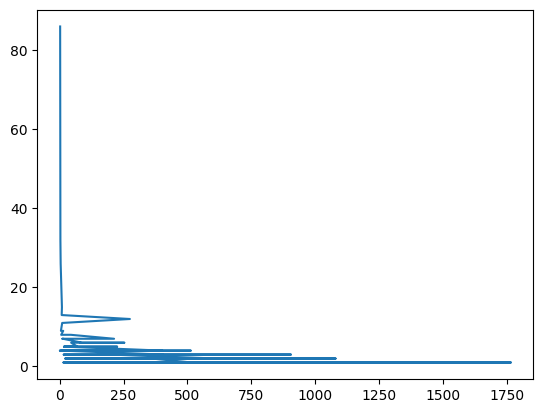

In [13]:
refined_df['time_since_last_commit_days'].value_counts().plot()

<AxesSubplot: >

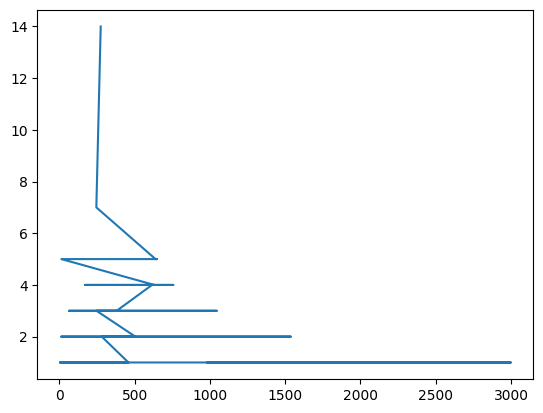

In [14]:
refined_df['age_days'].value_counts().plot()

In [15]:
refined_df.language.value_counts()

Python              455
Jupyter Notebook    270
Go                   29
TypeScript           24
HTML                 24
JavaScript           16
Shell                13
Java                 11
CSS                   7
C++                   6
Dockerfile            6
HCL                   6
C#                    5
R                     5
Rust                  5
Smarty                4
Makefile              4
Bicep                 2
SCSS                  2
TeX                   2
Mustache              2
Scala                 1
Vue                   1
VBA                   1
PowerShell            1
SAS                   1
Ruby                  1
PureBasic             1
PLpgSQL               1
Kotlin                1
Julia                 1
YAML                  1
Name: language, dtype: int64

# PCA for numeric data

In [16]:
numeric_df = (refined_df
    >> select(_.stargazers_count,
    _.has_issues,
    _.has_projects,
    _.has_downloads,
    _.has_wiki,
    _.has_pages,
    _.has_discussions,
    _.open_issues_count,
    _.allow_forking,
    _.is_template,
    _.age_days,
    _.time_since_last_commit_days)
    )

numeric_df.columns

Index(['stargazers_count', 'has_issues', 'has_projects', 'has_downloads',
       'has_wiki', 'has_pages', 'has_discussions', 'open_issues_count',
       'allow_forking', 'is_template', 'age_days',
       'time_since_last_commit_days'],
      dtype='object')

In [17]:
numeric_df.corr()

,stargazers_count,has_issues,has_projects,has_downloads,has_wiki,has_pages,has_discussions,open_issues_count,allow_forking,is_template,age_days,time_since_last_commit_days
stargazers_count,1.000000,0.021781,-0.002645,0.005431,-0.092477,0.100473,0.172367,0.452322,NaN,-0.016101,0.321221,-0.143490
has_issues,0.021781,1.000000,0.419024,-0.004744,0.328706,-0.002435,0.034458,0.023713,NaN,-0.011656,-0.044660,0.081786
has_projects,-0.002645,0.419024,1.000000,-0.008671,0.721320,-0.032895,-0.053396,-0.012836,NaN,0.026851,-0.078842,0.141476
has_downloads,0.005431,-0.004744,-0.008671,1.000000,0.089662,0.011830,0.011349,0.003604,NaN,0.005530,0.008794,0.027340
has_wiki,-0.092477,0.328706,0.721320,0.089662,1.000000,-0.115052,-0.167513,-0.154708,NaN,-0.011668,-0.118226,0.188112
has_pages,0.100473,-0.002435,-0.032895,0.011830,-0.115052,1.000000,0.222181,0.080330,NaN,-0.032382,0.044063,-0.152249
has_discussions,0.172367,0.034458,-0.053396,0.011349,-0.167513,0.222181,1.000000,0.273247,NaN,0.024793,0.142946,-0.215547
open_issues_count,0.452322,0.023713,-0.012836,0.003604,-0.154708,0.080330,0.273247,1.000000,NaN,-0.023169,0.328463,-0.153176
allow_forking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_template,-0.016101,-0.011656,0.026851,0.005530,-0.011668,-0.032382,0.024793,-0.023169,NaN,1.000000,-0.018990,-0.074351


# PCA of numeric repo data

## not scaled

In [18]:
pca_numeric = PCA(n_components=2).fit(numeric_df)
pca_numeric_output = pca_numeric.transform(numeric_df)


In [19]:
pca_numeric.components_

array([[ 9.95610794e-01,  1.85617259e-06, -7.87585703e-07,
         1.05675317e-07, -1.82735922e-05,  2.06695905e-05,
         3.46590894e-05,  2.29590032e-02,  0.00000000e+00,
        -1.70588240e-06,  8.77093793e-02, -2.32183962e-02],
       [-7.62544926e-02, -1.16923350e-05, -2.86296233e-05,
         9.67893173e-07, -3.60417287e-05, -1.57969198e-05,
         3.29744387e-05,  3.07066444e-02, -0.00000000e+00,
        -1.23099898e-05,  9.42950666e-01,  3.22624228e-01]])

In [20]:
# https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
# good PCA refresher https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e


def pca_plot(transformed_data, components):

    x = transformed_data[:, 0]
    y = transformed_data[:, 1]
    n = components.shape[0]

    plt.scatter(x, y)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
    for i in range(n):
        plt.arrow(0, 0, components[i, 0], components[i, 1], color="black", alpha=0.5)
        plt.text(
            components[i, 0] * 1.3,
            components[i, 1] * 1.3,
            "Var " + str(i + 1),
            color="black",
            ha="center",
            va="center",
        )

def most_important_feature(components, data):
    most_important = [np.abs(components[i]).argmax() for i in range(components.shape[0])]

    initial_feature_names = data.columns

    most_important_names = [initial_feature_names[most_important[i]] for i in range(components.shape[0])]

    dic = {'PC{}'.format(i): most_important_names[i] for i in range(components.shape[0])}


    return pd.DataFrame(dic.items())

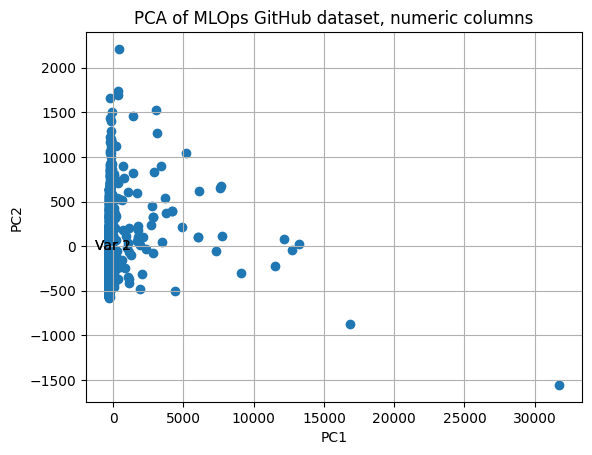

In [21]:
plt.title("PCA of MLOps GitHub dataset, numeric columns")
pca_plot(pca_numeric_output, pca_numeric.components_) 
plt.show()

In [22]:
most_important_feature(pca_numeric.components_, numeric_df)

,0,1
0,PC0,stargazers_count
1,PC1,age_days


## scaled

should i transform this data? feature scaling https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

In [23]:
scaled_numeric_df = StandardScaler().fit_transform(numeric_df)
pca_numeric_scaled = PCA(n_components=2).fit(scaled_numeric_df)
pca_numeric_scaled_output = pca_numeric_scaled.transform(scaled_numeric_df)

what does this mean?

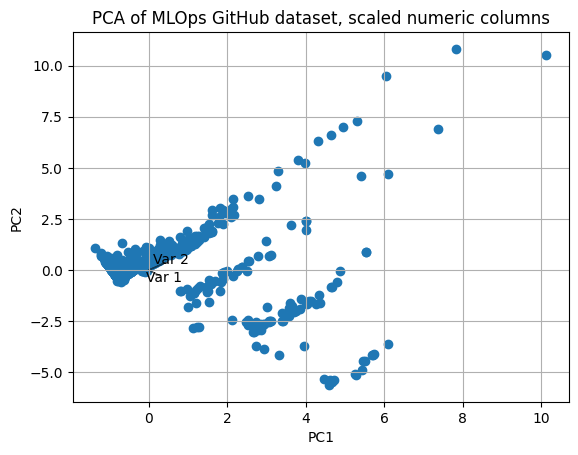

In [24]:
plt.title("PCA of MLOps GitHub dataset, scaled numeric columns")

pca_plot(pca_numeric_scaled_output, pca_numeric_scaled.components_) 
plt.show()

In [25]:
most_important_feature(pca_numeric_scaled.components_, numeric_df)

,0,1
0,PC0,has_wiki
1,PC1,open_issues_count


## what about the self labeled topics at the repo level?

In [26]:
refined_df.topics.iloc[0]

['data-engineering',
 'data-science',
 'deep-learning',
 'machine-learning',
 'mlops',
 'natural-language-processing',
 'python',
 'pytorch']

In [27]:
from collections import Counter

all_topics = (
    pd.DataFrame.from_dict(Counter(refined_df.topics.sum()), orient="index")
    .reset_index()
    .rename(columns={"index": "topics", 0: "n"})
)


In [28]:
(all_topics
    >> arrange(-_.n)
)

,topics,n
4,mlops,975
3,machine-learning,533
6,python,243
1,data-science,205
2,deep-learning,178
...,...,...
1739,full-stack,1
1740,plant,1
1741,plantdiseasedetection,1
1742,web,1


In [29]:
(all_topics
    >> filter(_.n > 1)
    >> count()
)

,n
0,657


In [30]:
all_topics['topics'] = all_topics.topics.str.replace("-", " ")
all_topics

,topics,n
0,data engineering,31
1,data science,205
2,deep learning,178
3,machine learning,533
4,mlops,975
...,...,...
1739,full stack,1
1740,plant,1
1741,plantdiseasedetection,1
1742,web,1


## what about licenses?

In [31]:
refined_df['license'] = refined_df.license.apply(pd.Series, dtype = 'object').key

In [32]:
refined_df.license.astype("category")

0              mit
1       apache-2.0
2              mit
3              mit
4       apache-2.0
           ...    
1039           NaN
1040           NaN
1041           NaN
1042           mit
1043           mit
Name: license, Length: 1023, dtype: category
Categories (13, object): ['agpl-3.0', 'apache-2.0', 'bsd-2-clause', 'bsd-3-clause', ..., 'mit', 'mit-0', 'mpl-2.0', 'other']

In [33]:
refined_df

,id,node_id,name,full_name,owner,description,created_at,updated_at,pushed_at,stargazers_count,...,has_wiki,has_pages,has_discussions,open_issues_count,license,allow_forking,is_template,topics,age_days,time_since_last_commit_days
0,156157055,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,Made-With-ML,GokuMohandas/Made-With-ML,"{'login': 'GokuMohandas', 'id': 8000987, 'node...","Learn how to responsibly develop, deploy and m...",2018-11-05 03:44:27,2023-01-18T14:24:54Z,2022-11-08 13:52:44,32107,...,True,False,False,6,mit,True,False,"[data-engineering, data-science, deep-learning...",1537,73
1,240315046,MDEwOlJlcG9zaXRvcnkyNDAzMTUwNDY=,jina,jina-ai/jina,"{'login': 'jina-ai', 'id': 60539444, 'node_id'...",🔮 Build multimodal AI services via cloud nativ...,2020-02-13 17:04:44,2023-01-18T14:18:14Z,2023-01-18 16:21:18,17144,...,False,True,False,33,apache-2.0,True,False,"[aiops, airflow, cloud-native, creative-ai, cr...",1072,2
2,144863525,MDEwOlJlcG9zaXRvcnkxNDQ4NjM1MjU=,awesome-production-machine-learning,EthicalML/awesome-production-machine-learning,"{'login': 'EthicalML', 'id': 43532924, 'node_i...",A curated list of awesome open source librarie...,2018-08-15 14:28:41,2023-01-18T17:16:27Z,2023-01-16 06:42:25,13008,...,True,True,False,26,mit,True,False,"[awesome, awesome-list, data-mining, deep-lear...",1619,4
3,135673451,MDEwOlJlcG9zaXRvcnkxMzU2NzM0NTE=,nni,microsoft/nni,"{'login': 'microsoft', 'id': 6154722, 'node_id...",An open source AutoML toolkit for automate mac...,2018-06-01 05:51:44,2023-01-18T12:49:05Z,2023-01-18 09:27:55,12415,...,True,False,True,290,mit,True,False,"[automated-machine-learning, automl, bayesian-...",1694,2
4,192640529,MDEwOlJlcG9zaXRvcnkxOTI2NDA1Mjk=,label-studio,heartexlabs/label-studio,"{'login': 'heartexlabs', 'id': 48309720, 'node...",Label Studio is a multi-type data labeling and...,2019-06-19 02:00:44,2023-01-18T11:31:18Z,2023-01-18 17:09:25,11747,...,True,False,True,448,apache-2.0,True,False,"[annotation, annotation-tool, annotations, bou...",1311,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,580399205,R_kgDOIpgwZQ,step-functions-sagemaker-ml-pipeline,hkford/step-functions-sagemaker-ml-pipeline,"{'login': 'hkford', 'id': 82389275, 'node_id':...",ML pipeline with AWS Step Functions and Amazon...,2022-12-20 13:17:41,2022-12-20T13:33:21Z,2022-12-20 13:32:14,0,...,True,False,False,0,NaN,True,False,"[mlops, sagemaker, step-functions]",31,31
1040,472158586,R_kgDOHCSReg,genome,edeliu2000/genome,"{'login': 'edeliu2000', 'id': 8235794, 'node_i...",AI AutoML Platform Services for Managing Milli...,2022-03-21 02:18:15,2022-12-09T17:27:37Z,2023-01-10 23:03:03,0,...,True,False,False,0,NaN,True,False,"[automlops, configurable-ai, controllable-ai, ...",305,10
1041,499422453,R_kgDOHcSU9Q,ml-ops,khoaguin/ml-ops,"{'login': 'khoaguin', 'id': 88959106, 'node_id...",A Learning Journal on Machine Learning in Prod...,2022-06-03 07:38:42,2022-06-10T08:40:17Z,2023-01-16 07:24:02,0,...,True,False,False,0,NaN,True,False,[mlops],231,4
1042,575407571,R_kgDOIkwF0w,Plant-disease-Detection,shashank1623/Plant-disease-Detection,"{'login': 'shashank1623', 'id': 86946068, 'nod...",Plant Disease Detection using convolutional n...,2022-12-07 12:53:33,2023-01-10T17:25:44Z,2023-01-10 17:29:52,0,...,True,False,False,0,mit,True,False,"[adam-optimizer, cnn, d, deep-learning, develo...",44,10


## what do we know about the PRs?

In [38]:
prs_df = pd.DataFrame(issuespr_total)
prs_df.head()


,id,milestone_id,repository_id,user_id,body,closed_at,created_at,locked,number,state,title,updated_at,type
0,MDExOlB1bGxSZXF1ZXN0MjI4NDQ0MTI4,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T18:20:05Z,2018-11-05T18:14:37Z,False,1,MERGED,added instructions for running and contributin...,2018-11-05T18:20:05Z,PullRequest
1,MDExOlB1bGxSZXF1ZXN0MjI4NDQ2MDM3,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T18:21:46Z,2018-11-05T18:21:38Z,False,2,MERGED,fixed upload image link,2018-11-05T18:21:46Z,PullRequest
2,MDExOlB1bGxSZXF1ZXN0MjI4NDU3Mjg4,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T19:02:46Z,2018-11-05T19:02:25Z,False,3,MERGED,made readme more readable by adding linebreaks,2018-11-05T19:02:46Z,PullRequest
3,MDExOlB1bGxSZXF1ZXN0MjI4NDU3ODMy,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T19:04:31Z,2018-11-05T19:04:24Z,False,4,MERGED,fixed contribution instructions,2018-11-05T19:04:32Z,PullRequest
4,MDExOlB1bGxSZXF1ZXN0MjI4NDU4NTc0,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T19:07:24Z,2018-11-05T19:07:17Z,False,5,MERGED,fixed contributing instructions,2018-11-05T20:47:30Z,PullRequest


In [39]:
len(prs_df)

121704

In [41]:
(prs_df  
    >> filter(_.state == 'MERGED')
    >> count()
)

,n
0,100836


In [43]:
prs_small = (prs_df
    >> filter(_.state == 'MERGED')
    >> select(_.repository_id, _.title)
)

In [48]:
# copied from 03_clean_text.ipynb
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tokenizer = RegexpTokenizer(r'\w+')

pr_sents  = prs_small.title.to_list()
# Vectorize document using TF-IDF
pr_tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
pr_train_data = pr_tfidf.fit_transform(pr_sents)   
# Define the number of topics or components
num_components=10

# Create LDA object
pr_model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
pr_lda_matrix = pr_model.fit_transform(pr_train_data)

# Get Components 
pr_lda_components=pr_model.components_

AttributeError: 'LatentDirichletAllocation' object has no attribute 'components_'

In [46]:
# Print the topics with their terms
pr_terms = pr_tfidf.get_feature_names_out()

for index, component in enumerate(pr_lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['fix', 'add', 'docs', 'doc', 'update', 'lint', 'model']
Topic 1:  ['fix', 'add', 'docs', 'test', 'link', 'example', 'update']
Topic 2:  ['fix', 'error', 'add', 'message', 'feat', 'docs', 'remove']
Topic 3:  ['deps', 'update', 'dependency', 'chore', '0', '1', 'v1']
Topic 4:  ['readme', 'md', 'update', 'docs', 'remove', 'add', 'updated']
Topic 5:  ['typo', 'fix', 'components', 'merge', 'add', 'docs', 'google']
Topic 6:  ['fix', 'add', 'docs', 'feature', 'dagit', 'tests', 'feat']
Topic 7:  ['0', '1', 'bump', '2', '3', 'release', 'version']
Topic 8:  ['ci', 'test', 'fix', 'add', 'dev', 'v0', 'build']
Topic 9:  ['fix', 'add', 'feat', 'support', 'refactor', 'api', 'type']


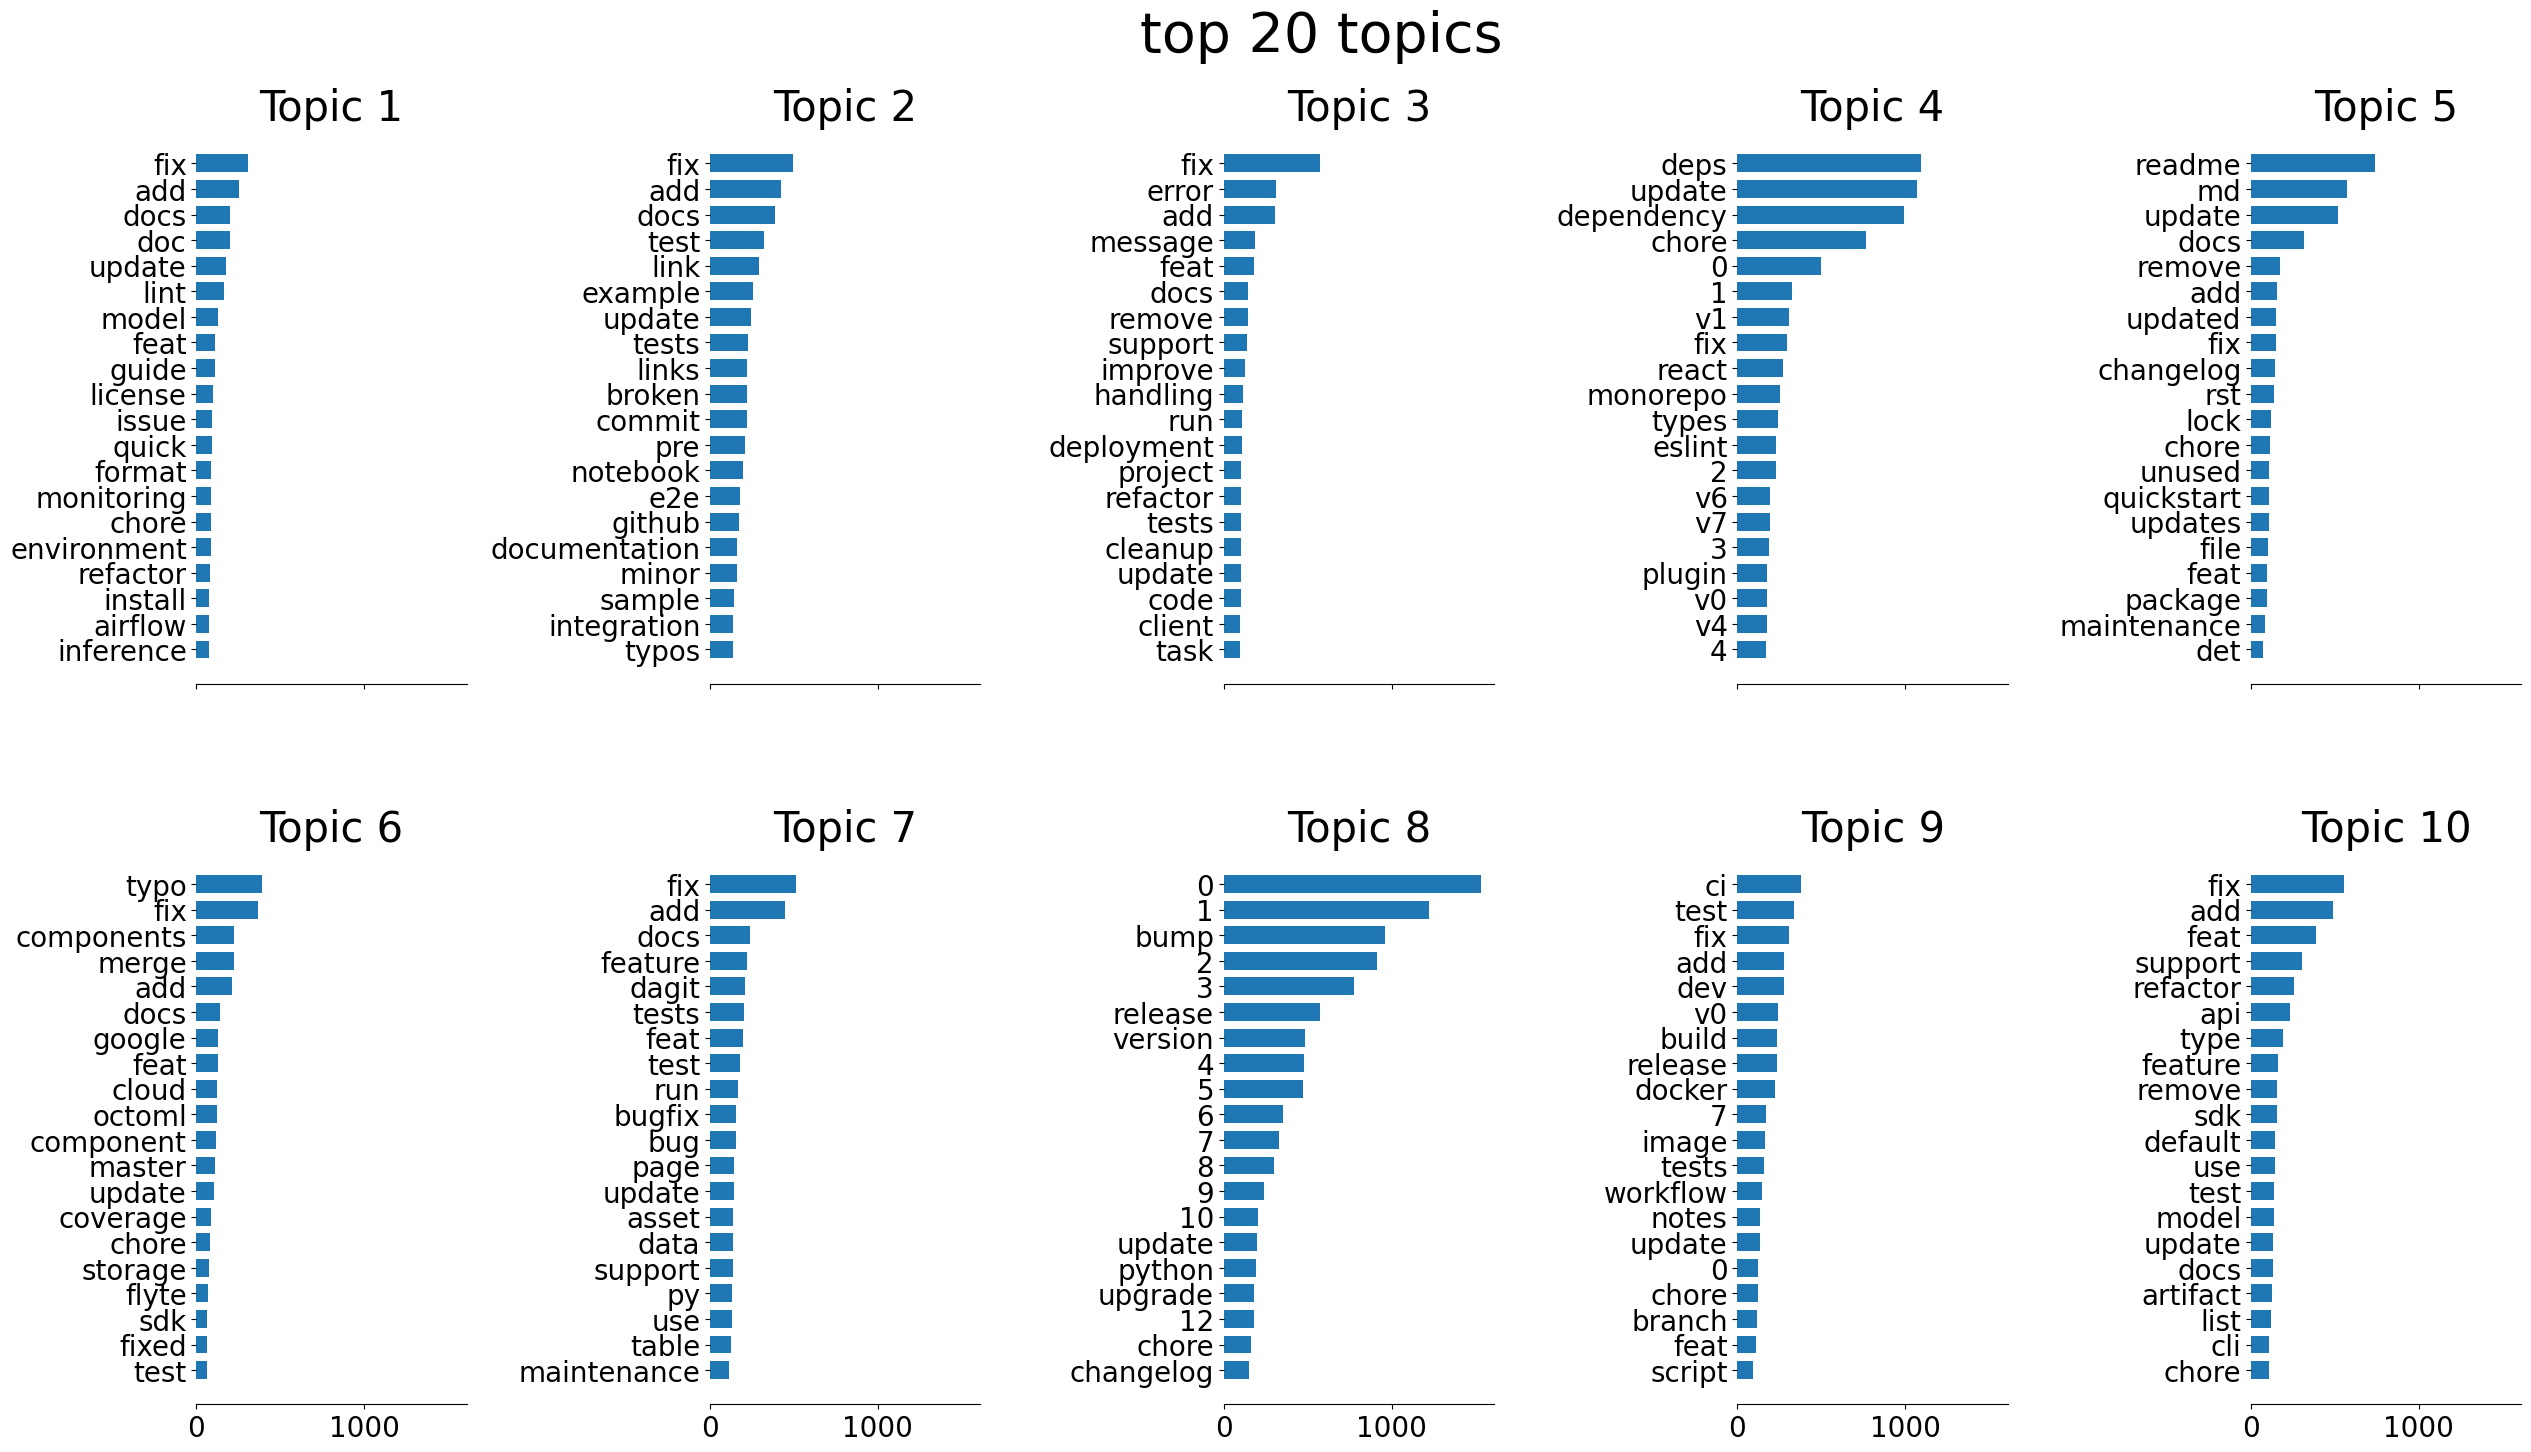

In [47]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(pr_model, pr_tfidf.get_feature_names_out(), 20, "top 10 topics")

okay, so all the topics are around maintainance, not necessarily features or mlops-y tasks. this is pretty expected

## what about issues?

looking at issues titles, not body

In [50]:
issues_df = pd.DataFrame(issues_total)
issues_df.head()

,id,milestone_id,repository_id,user_id,body,closed_at,created_at,locked,number,state,title,updated_at,type
0,MDU6SXNzdWUzODk2NzE0MDM=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjExNTMwMjQ3,Great repo!\r\nCan i translate it to Chinese?,2018-12-11T11:14:53Z,2018-12-11T09:37:03Z,False,69,CLOSED,Chinese translation,2022-09-16T08:27:39Z,Issue
1,MDU6SXNzdWUzOTA0OTEwMzg=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjIyOTU5MDM3,Is it okay to contribute to segmentation part ...,2018-12-13T16:22:16Z,2018-12-13T02:25:32Z,False,76,CLOSED,Contribution to Computer Vision?,2018-12-13T16:22:16Z,Issue
2,MDU6SXNzdWUzOTA1NDQ4OTM=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjI3MTQzMDU4,Could u pls release a instruction on Jupyter n...,2018-12-13T13:33:46Z,2018-12-13T07:05:19Z,False,78,CLOSED,Notebook,2018-12-13T13:33:46Z,Issue
3,MDU6SXNzdWUzOTA3NDQ3OTQ=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjcwMDYxNw==,In the [numpy notebook](https://github.com/Gok...,2018-12-13T16:22:02Z,2018-12-13T16:00:06Z,False,83,CLOSED,3d or 2d numpy array?,2018-12-13T16:22:02Z,Issue
4,MDU6SXNzdWUzOTI3NTY3OTc=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjExNTU1NzM=,"Hi @GokuMohandas,\r\n\r\nI've been recently ta...",2018-12-25T20:42:17Z,2018-12-19T20:02:14Z,False,90,CLOSED,Alternative to Colab and Binder for running `p...,2018-12-26T15:44:03Z,Issue


In [51]:
len(issues_df)

55994

In [52]:
issues_sents  = issues_df.title.to_list()
# Vectorize document using TF-IDF
issues_tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
issues_train_data = issues_tfidf.fit_transform(pr_sents)   
# Define the number of topics or components
num_components=10

# Create LDA object
issues_model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
issues_lda_matrix = issues_model.fit_transform(pr_train_data)

# Get Components 
issues_lda_components = issues_model.components_

In [53]:
# Print the topics with their terms
issues_terms = issues_tfidf.get_feature_names_out()

for index, component in enumerate(issues_lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['fix', 'add', 'feat', 'commit', 'pre', 'api', 'file']
Topic 1:  ['fix', 'tests', 'test', 'add', 'feature', 'integration', 'broken']
Topic 2:  ['fix', 'add', 'feat', 'support', 'refactor', 'cli', 'api']
Topic 3:  ['0', '1', 'bump', '2', '3', 'release', '7']
Topic 4:  ['docs', 'add', 'fix', 'requirements', 'update', 'deployment', 'notes']
Topic 5:  ['deps', 'update', 'chore', 'dependency', 'eslint', 'fix', '0']
Topic 6:  ['fix', 'typo', 'add', 'docs', 'remove', 'dagit', 'feat']
Topic 7:  ['readme', 'md', 'update', 'docs', 'add', 'fix', 'updated']
Topic 8:  ['fix', 'add', 'ci', 'build', 'docker', 'master', 'test']
Topic 9:  ['update', 'deps', 'dependency', 'fix', 'chore', '0', 'react']


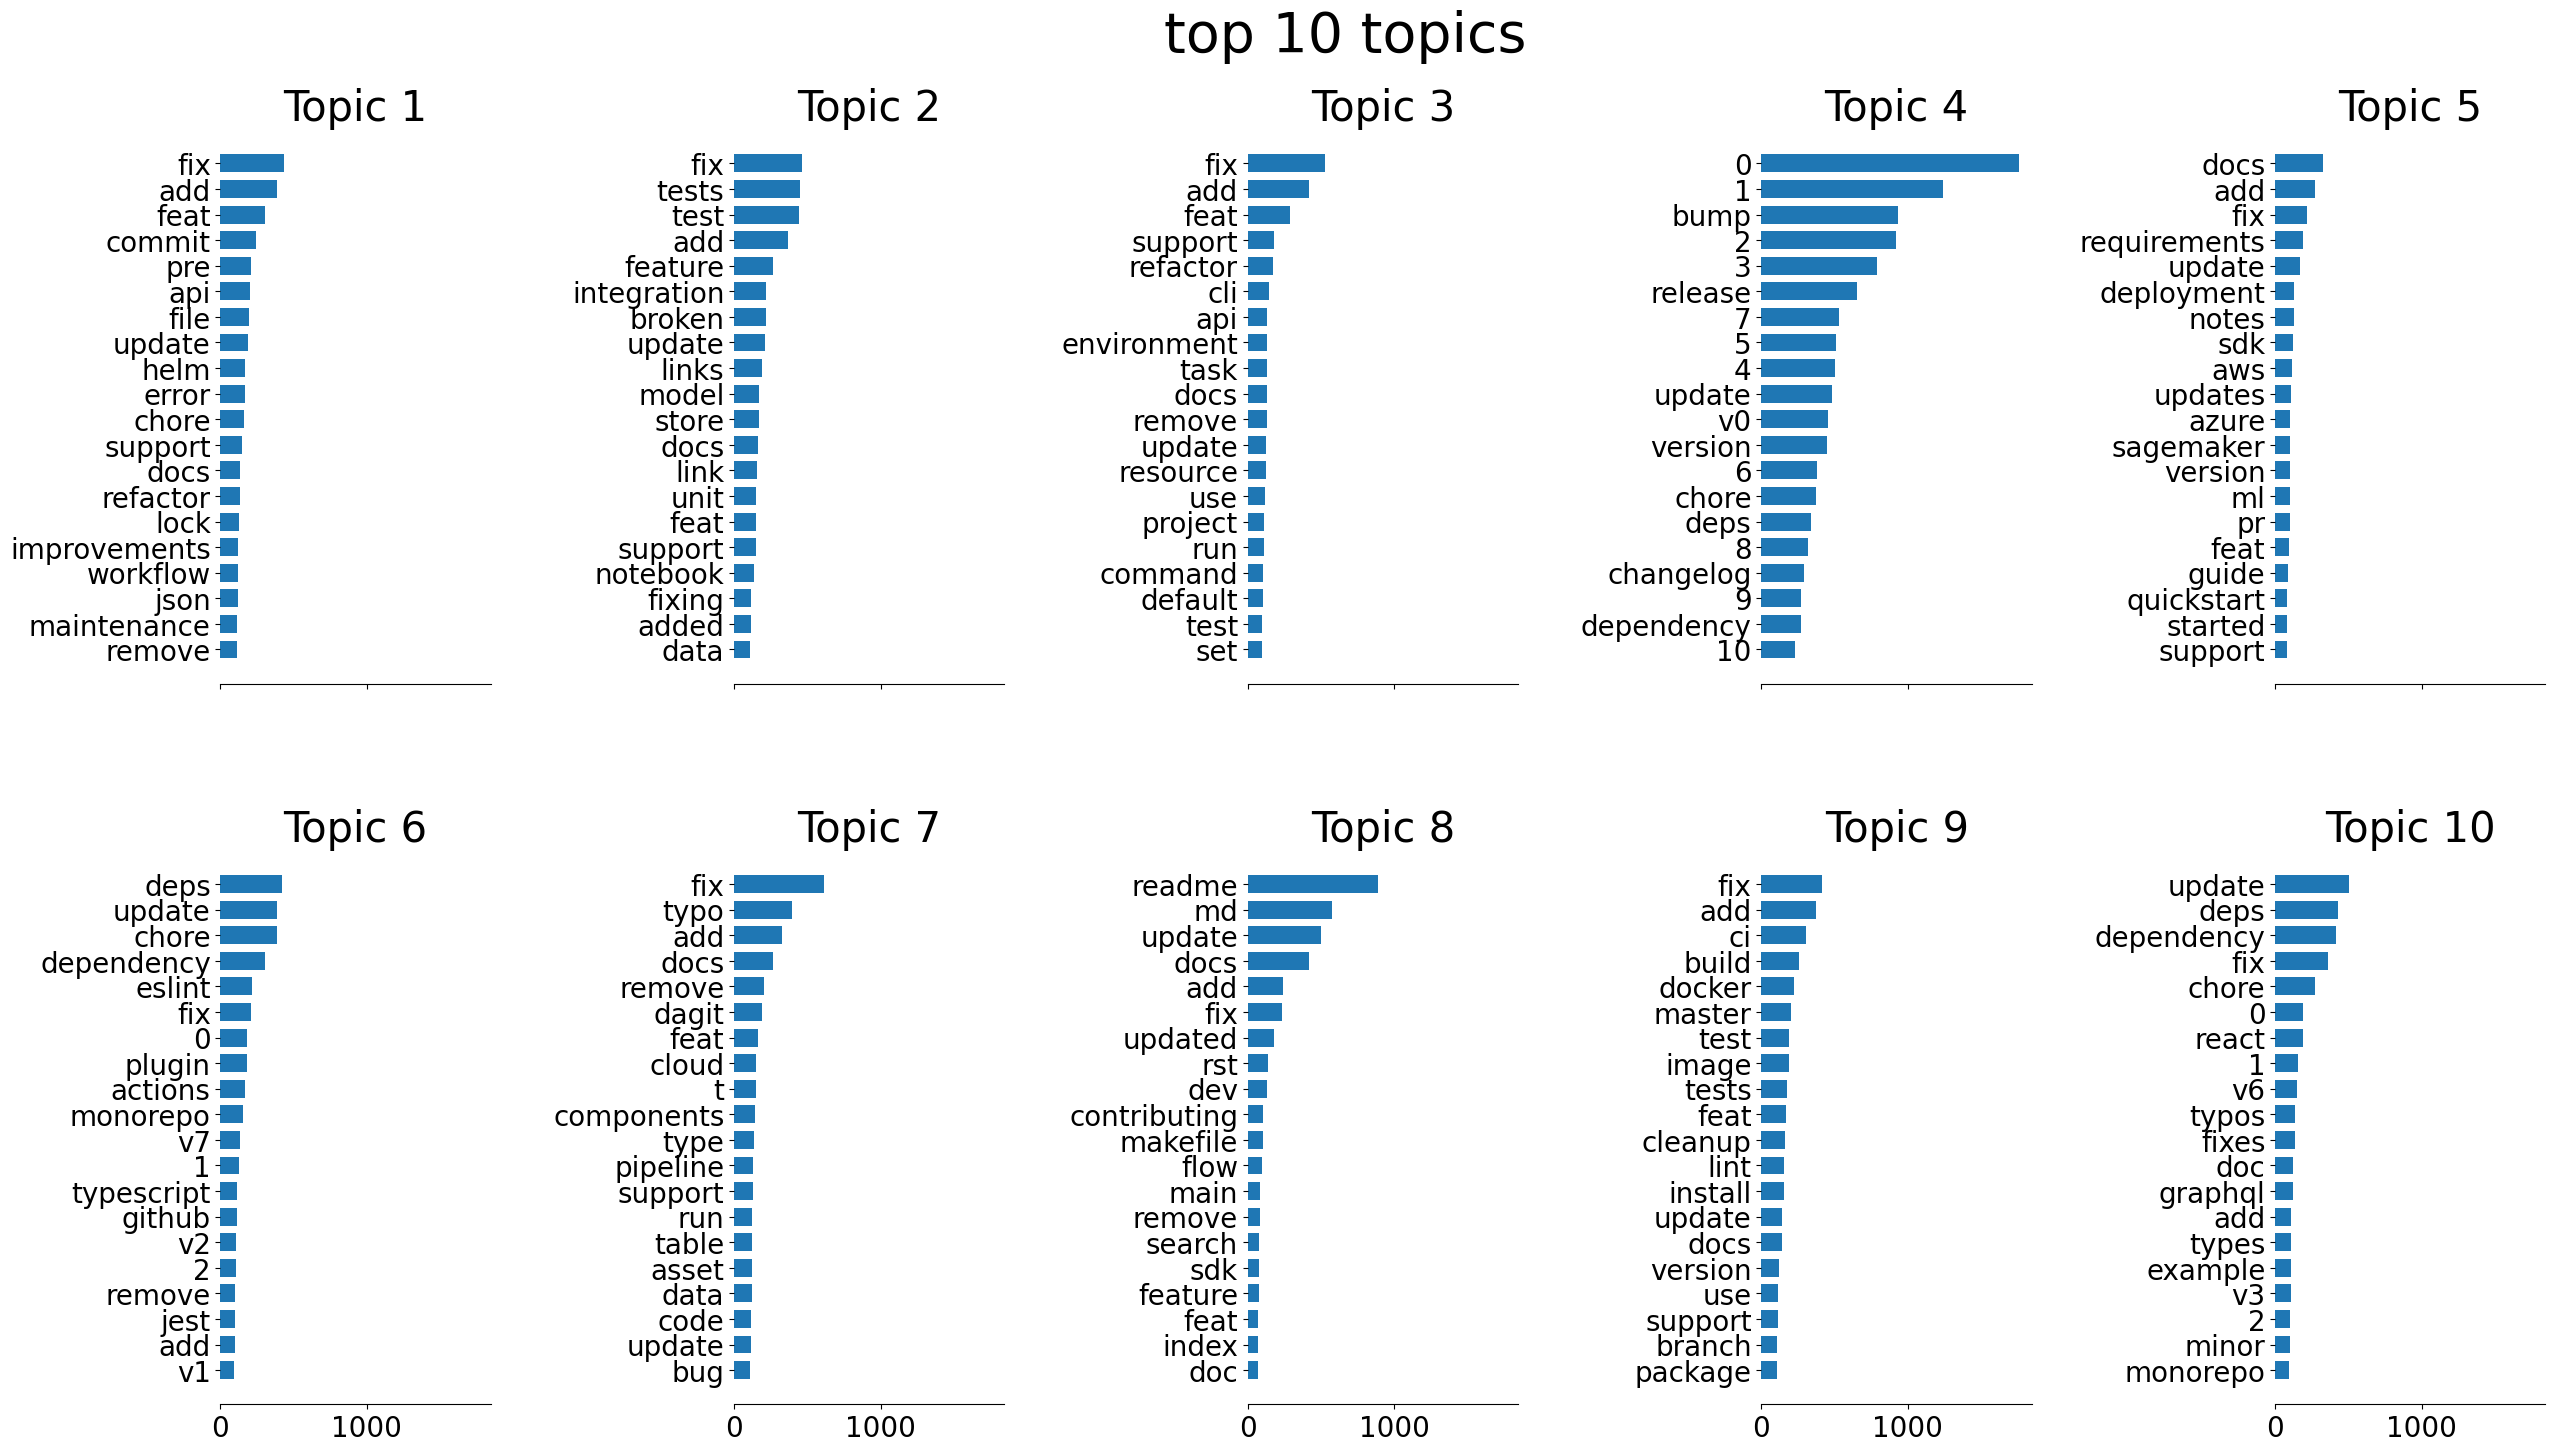

In [54]:
plot_top_words(issues_model, issues_tfidf.get_feature_names_out(), 20, "top 10 topics")